In [1]:
# import keras
import keras

Using TensorFlow backend.


In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from zipfile import ZipFile

filename = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/'
#with ZipFile(filename) as z:
 # z.extractall()

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/')

In [5]:
pwd

'/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data'

In [0]:
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

In [7]:
! pip install keras_maskrcnn

     |████████████████████████████████| 61kB 5.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/0b/03/0e/652a317641021f3450b92b69567e64cc54597d71e809426be8
  Stored in directory: /root/.cache/pip/wheels/d9/a5/98/87f8ed08913b184bb625dde1c1277a4dfe969c77b377abde69
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-maskrcnn keras-retinanet keras-resnet


In [0]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [0]:
wt_file = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/resnet50_coco_v0.2.0.h5'

In [0]:
model_path = wt_file

In [12]:
model = models.load_model(model_path)

W0728 19:59:41.406575 139926302590848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 19:59:41.456707 139926302590848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0728 19:59:41.769237 139926302590848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras_retinanet/backend/tensorflow_backend.py:68: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

W0728 19:59:41.800951 139926302590848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 19:59:41.856691 139926302590848 deprecation_wrappe

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           image[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [0]:
# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

In [0]:
def predict_image(image_name):
  # load image
  image = read_image_bgr(image_name)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  boxes  = outputs[-4][0]
  scores = outputs[-3][0]
  labels = outputs[-2][0]
  masks  = outputs[-1][0]
  
  print(boxes.shape)
  print(scores.shape)
  print(labels.shape)
  print(masks.shape)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label, mask in zip(boxes, scores, labels, masks):
      if score < 0.5:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      mask = mask[:, :, label]
      draw_mask(draw, b, mask, color=label_color(label))

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()
  return boxes,scores,labels,masks

processing time:  9.020616054534912


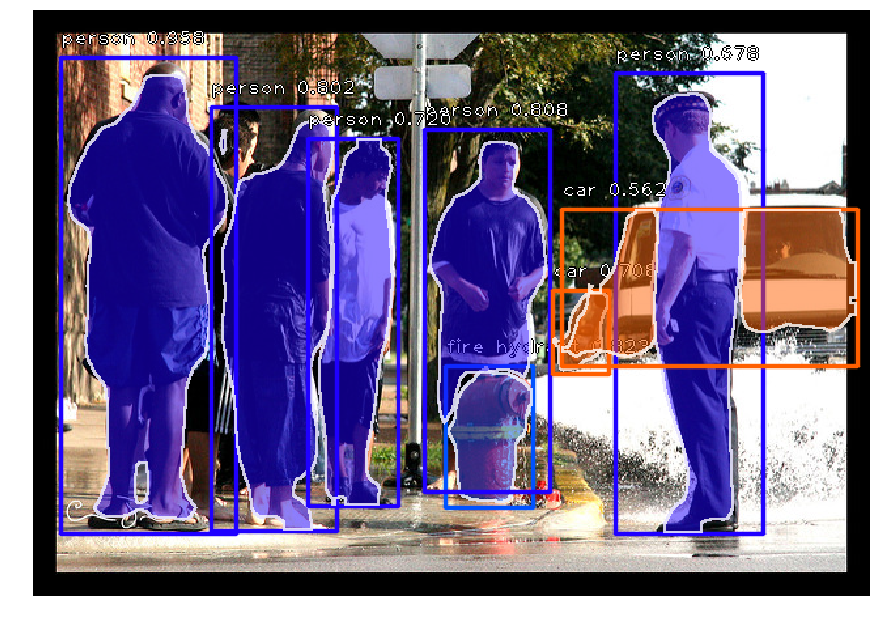

In [0]:
images_path = '/content/drive/My Drive/AIML Notes/InstanceSegmentation/'
predict_image(images_path + '1.jpg')

processing time:  4.076305389404297


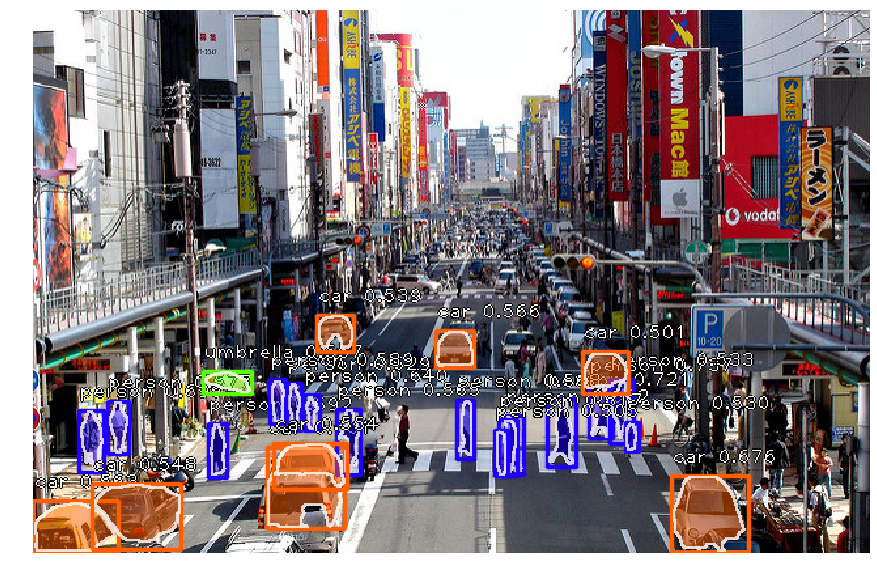

In [0]:
predict_image(images_path + '2.jpg')

processing time:  3.976656675338745


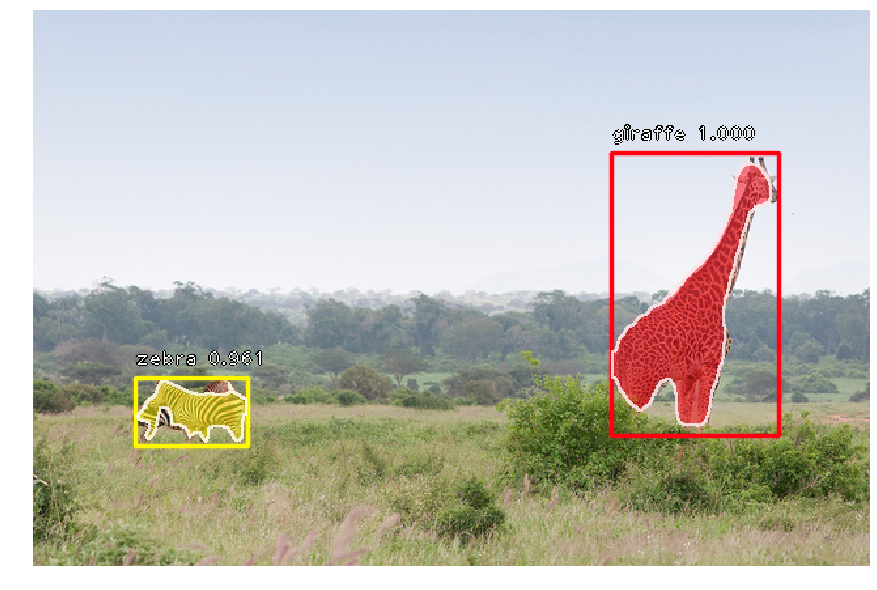

In [0]:
predict_image(images_path + '3.jpg')

processing time:  1.2823400497436523


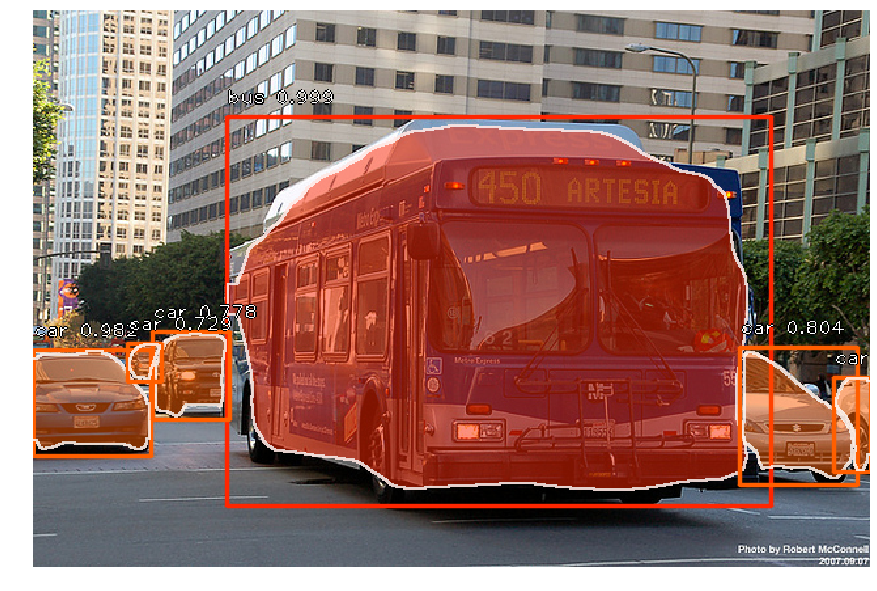

In [0]:
predict_image(images_path + '4.jpg')

processing time:  0.28878211975097656
(100, 4)
(100,)
(100,)
(100, 28, 28, 80)


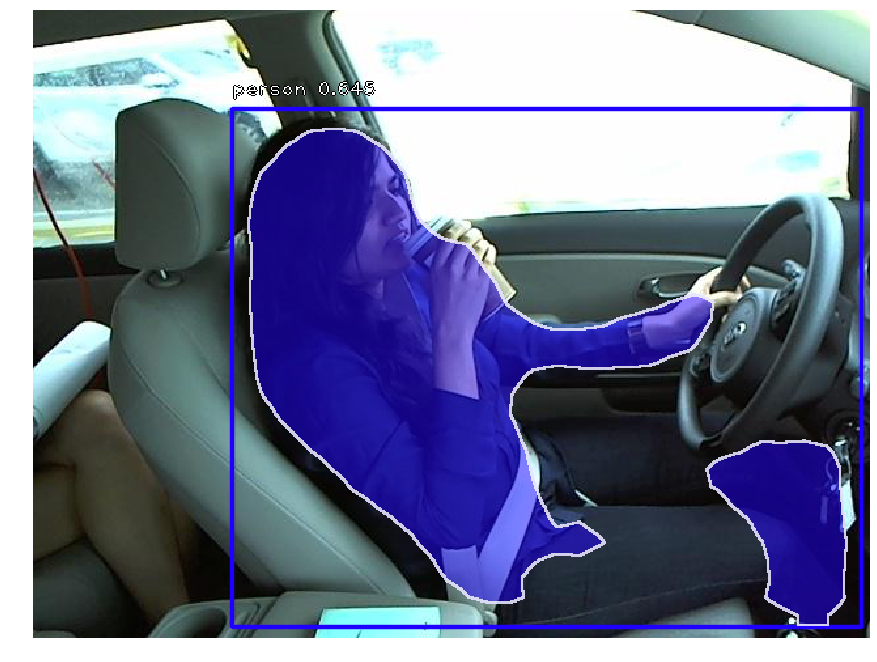

In [27]:
images_path = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/Box Data/'
predict_image(images_path + 'img_0.jpg')

processing time:  0.2745671272277832
(100, 4)
(100,)
(100,)
(100, 28, 28, 80)


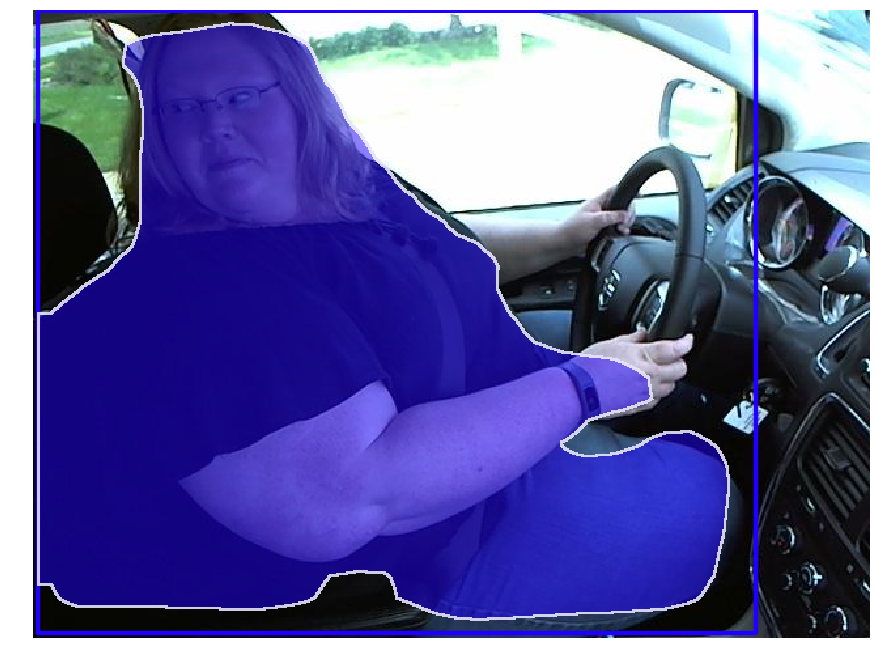

In [28]:
images_path = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/Box Data/'
predict_image(images_path + 'img_54.jpg')

processing time:  0.27756810188293457


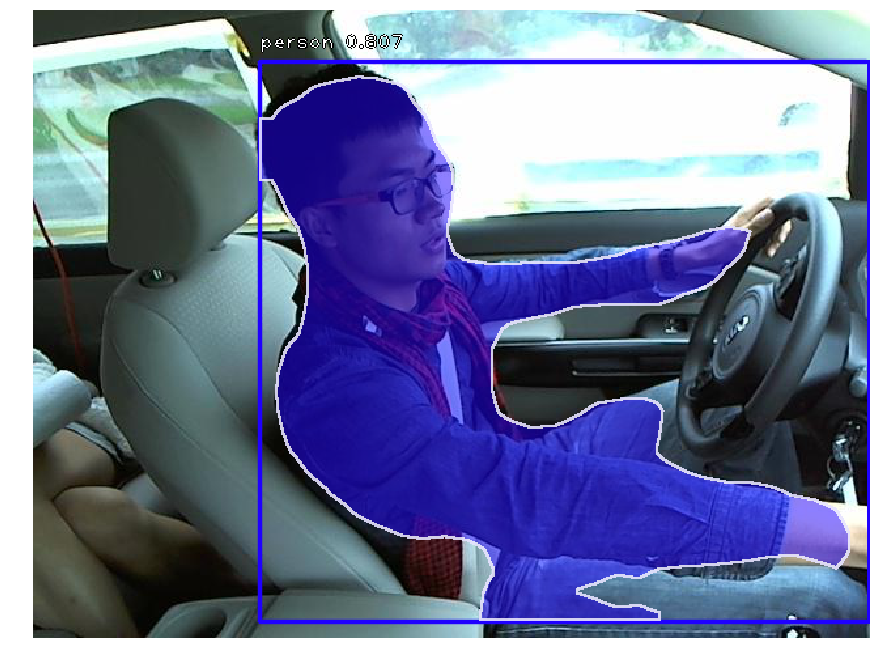

In [19]:
predict_image(images_path + 'img_118.jpg')

processing time:  0.29949522018432617


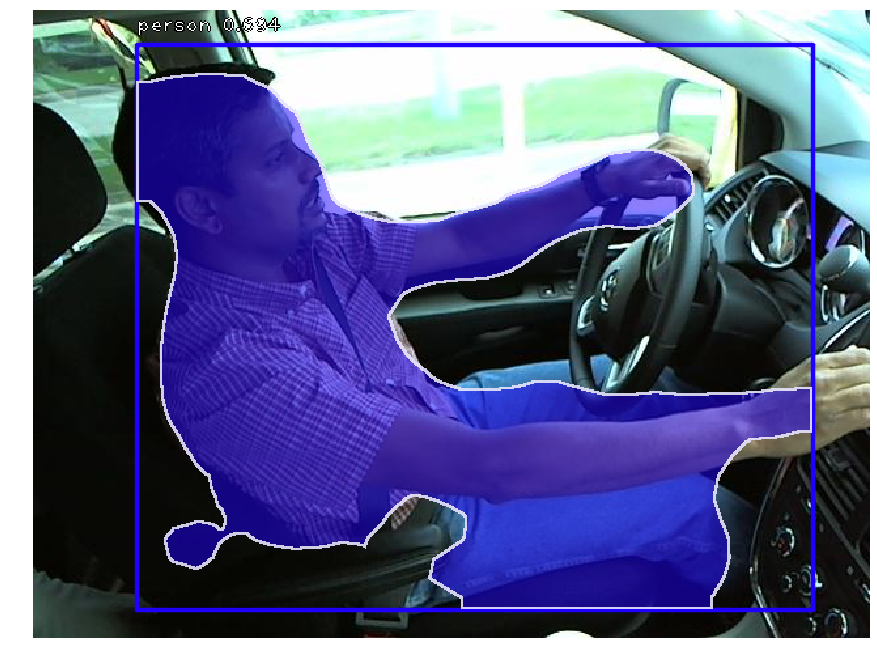

In [20]:
predict_image(images_path + 'img_120.jpg')

processing time:  0.28708672523498535


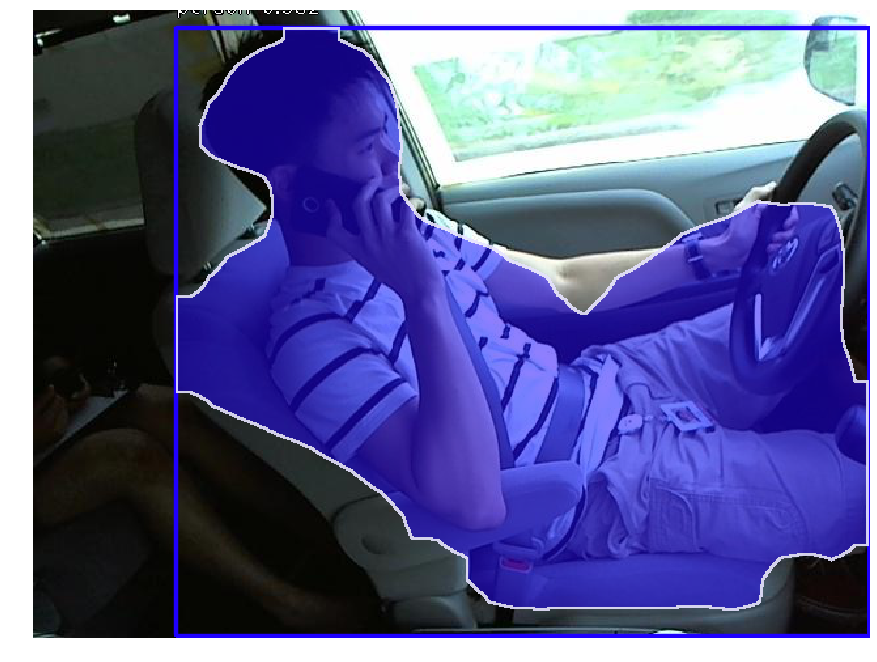

In [21]:
predict_image(images_path + 'img_94.jpg')

processing time:  0.301220178604126
(100, 4)
(100,)
(100,)
(100, 28, 28, 80)


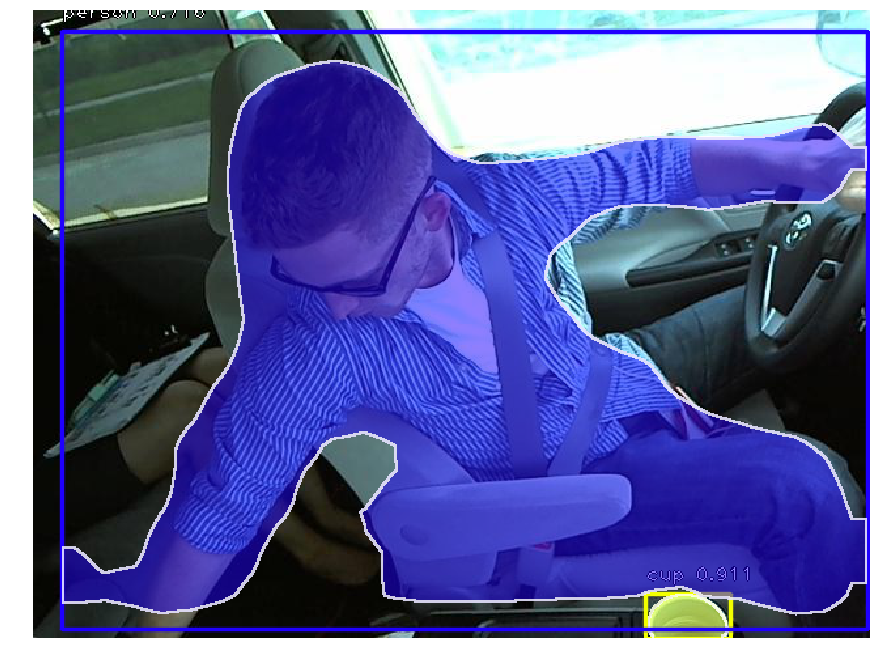

In [31]:
boxes,scores,labels,masks = predict_image(images_path + 'img_81.jpg')

processing time:  0.2885606288909912


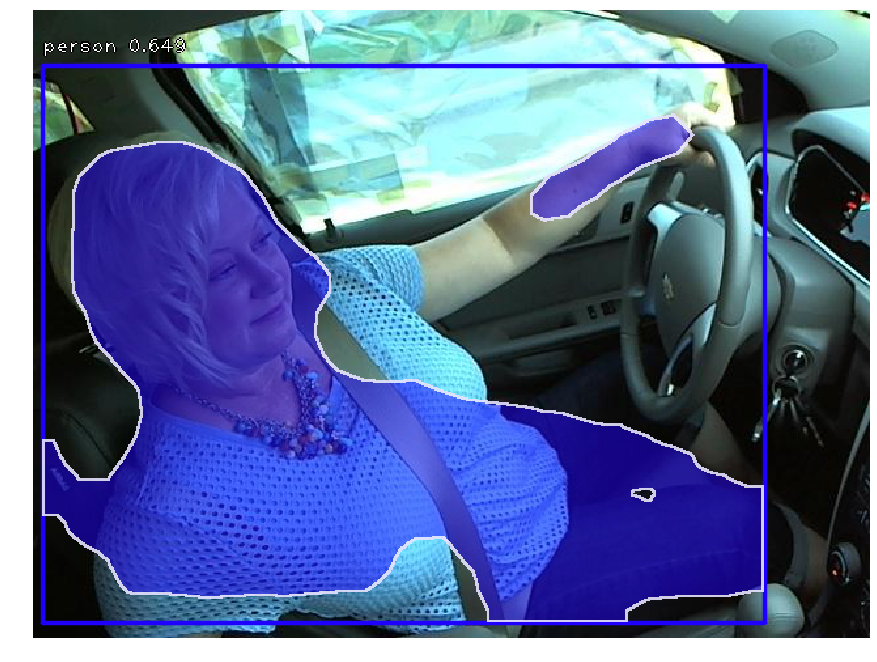

In [23]:
predict_image(images_path + 'img_102.jpg')

In [0]:
boxes,scores,labels,masks

processing time:  0.3022325038909912
(100, 4)
(100,)
(100,)
(100, 28, 28, 80)


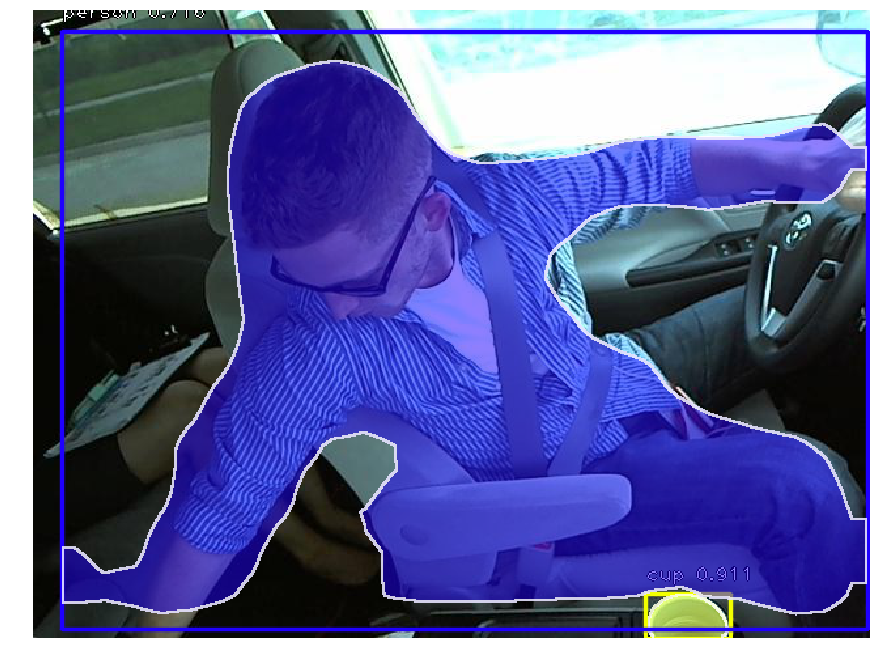

22
16
638
473


In [55]:
boxes,scores,labels,masks = predict_image(images_path + 'img_81.jpg')
for box, score, label, mask in zip(boxes, scores, labels, masks):
      if score < 0.5:
          break
      x = int(box[0])
      y = int(box[1])
      w = int(box[2])
      h = int(box[3])
print(x)
print(y)
print(w)
print(h)

(464, 618, 3)

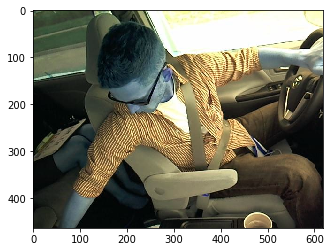

In [57]:
import cv2
img = cv2.imread(images_path + 'img_81.jpg')
crop_img = img[y:y+h, x:x+w].copy()
plt.imshow(crop_img)
cv2.waitKey(0)
crop_img.shape

processing time:  0.2962076663970947
(100, 4)
(100,)
(100,)
(100, 28, 28, 80)


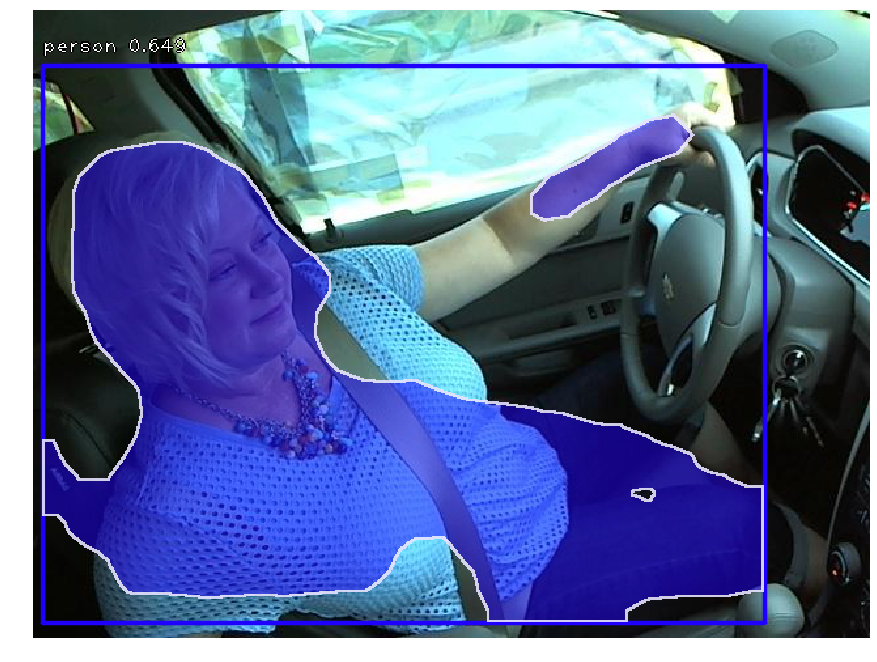

7
42
559
468


In [58]:
boxes,scores,labels,masks = predict_image(images_path + 'img_102.jpg')
for box, score, label, mask in zip(boxes, scores, labels, masks):
      if score < 0.5:
          break
      x = int(box[0])
      y = int(box[1])
      w = int(box[2])
      h = int(box[3])
print(x)
print(y)
print(w)
print(h)

(438, 559, 3)

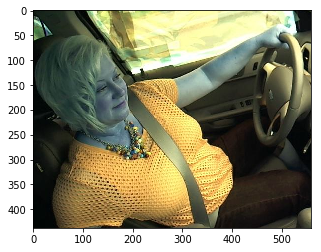

In [59]:
import cv2
img = cv2.imread(images_path + 'img_102.jpg')
crop_img = img[y:y+h, x:x+w].copy()
plt.imshow(crop_img)
cv2.waitKey(0)
crop_img.shape